In [ ]:
from music21 import *
from IPython.display import Image

us = environment.UserSettings()
# work computers location
us["musicxmlPath"] = (
    "C:/Users/circ8/Documents/Chris/MuseScorePortableLegacy3/MuseScorePortable.exe"
)
# macOS location
# us['musicxmlPath'] = '/Applications/MuseScore 3.app/Contents/MacOS/mscore'


def music(notes: str, midi: bool = False):
    s = stream.Score()
    part = stream.Part()

    # get info
    info_start = 5

    for i in range(info_start, len(notes)):
        if notes[i : i + 5] == "INFO ":
            info_end = i

    info = list(filter(lambda x: len(x) > 0, notes[info_start:info_end].split(" ")))

    # set clef
    if info[0].lower() == "treble":
        s.append(instrument.AcousticGuitar())
        part.append(clef.TrebleClef())
    elif info[0].lower() == "bass":
        part.append(clef.BassClef())
    elif info[0].lower() == "guitar":
        part.append(clef.Treble8vbClef())

    # set key
    keys = [
        ["cb", -7],
        ["gb", -6],
        ["db", -5],
        ["ab", -4],
        ["eb", -3],
        ["bb", -2],
        ["f", -1],
        ["c", 0],
        ["g", 1],
        ["d", 2],
        ["a", 3],
        ["e", 4],
        ["b", 5],
        ["f#", 6],
        ["c#", 7],
    ]
    for k in keys:
        if info[1].lower() == k[0]:
            part.append(key.KeySignature(k[1]))

    # set time signature
    part.append(meter.TimeSignature(info[2]))

    # set tempo
    s.append(tempo.MetronomeMark(number=int(info[3])))

    # add notes
    notes = notes[info_end + 5 :].split(" ")
    add_notes = []
    for n in notes:
        # add chord name
        if n[0] == "!":
            add_notes.append(harmony.ChordSymbol(n[1:]))
        # start next measure on a new line
        elif n == "^":
            add_notes.append(layout.SystemLayout(isNew=True))
        else:
            # set variables
            is_chord, is_tie, is_col, lyric = False, "none", "", ""
            # if the note is a chord
            if "(" in n:
                is_chord = True
                if "[" in n:
                    for i in range(len(n)):
                        if n[i] == "[":
                            lyric_start = i + 1
                        if n[i] == "]":
                            lyric_end = i
                    lyric = n[lyric_start:lyric_end]
                    n = n[: lyric_start - 1]
                note_name = n.replace("(", "").replace(")", "").split(",")
                if "t" in note_name[-1]:
                    note_length = note_name[-1][-2:]
                    note_name[-1] = note_name[-1][:-2]
                else:
                    note_length = note_name[-1][-1]
                    note_name[-1] = note_name[-1][:-1]
            else:
                if "{" in n:
                    is_tie = "start"
                if "}" in n:
                    is_tie = "stop"
                if "[" in n:
                    for i in range(len(n)):
                        if n[i] == "[":
                            lyric_start = i + 1
                        if n[i] == "]":
                            lyric_end = i
                    lyric = n[lyric_start:lyric_end]
                    n = n[: lyric_start - 1]
                if n[-1] == "t":
                    if n[0] == "B":
                        is_col = "#06538a"
                        note_name = n[1:-2].replace("{", "").replace("}", "")
                    elif n[0] == "R":
                        is_col = "#8a062d"
                        note_name = n[1:-2].replace("{", "").replace("}", "")
                    else:
                        note_name = n[:-2].replace("{", "").replace("}", "")
                    note_length = n[-2:]
                else:
                    if n[0] == "B":
                        is_col = "#06538a"
                        note_name = n[1:-1].replace("{", "").replace("}", "")
                    elif n[0] == "R":
                        is_col = "#8a062d"
                        note_name = n[1:-1].replace("{", "").replace("}", "")
                    else:
                        note_name = n[:-1].replace("{", "").replace("}", "")
                    note_length = n[-1:]
            lengths = [
                ["w", 4],
                ["h", 2],
                ["d", 3],
                ["q", 1],
                ["u", 1.5],
                ["e", 0.5],
                ["s", 0.25],
            ]
            for l in lengths:
                if isinstance(note_length, str):
                    if l[0] in note_length:
                        if "t" in note_length:
                            note_length = l[1] * 0.333333333
                        else:
                            note_length = l[1]
            if is_tie == "none":
                if is_col == "":
                    if lyric != "":
                        add_notes.append([note_name, note_length, lyric])
                    else:
                        add_notes.append([note_name, note_length])
                else:
                    if lyric != "":
                        add_notes.append([note_name, note_length, is_col, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_col])
            else:
                if is_col == "":
                    if lyric != "":
                        add_notes.append([note_name, note_length, is_tie, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_col, is_tie])
                else:
                    if lyric != "":
                        add_notes.append(
                            [note_name, note_length, is_tie, is_col, lyric]
                        )
                    else:
                        add_notes.append([note_name, note_length, is_tie, is_col])

    for n in add_notes:
        if isinstance(n, list):
            if isinstance(n[0], list):
                if len(n) == 3:
                    add_n = chord.Chord(n[0], quarterLength=n[1])
                    if n[2] in ["start", "stop"]:
                        add_n.tie = tie.Tie(n[2])
                    else:
                        if "-" in n[2]:
                            texp = expressions.TextExpression(n[2].replace("-", " "))
                        else:
                            texp = expressions.TextExpression(n[2])
                        texp.style.fontSize = 10
                        # texp.style.fontFamily = "Segoe UI"
                        texp.style.fontFamily = "Times New Roman"
                        texp.placement = "below"
                        part.append(texp)
                else:
                    add_n = chord.Chord(n[0], quarterLength=n[1])
            else:
                if n[0].lower() == "r":
                    add_n = note.Rest(quarterLength=n[1])
                elif n[0] in ["slash", "s"]:
                    add_n = note.Unpitched()
                    add_n.notehead = "slash"
                    add_n.stemDirection = "noStem"
                    add_n.volume.velocity = 0
                elif n[0] not in ["r", "slash", "s"]:
                    add_n = note.Note(n[0], quarterLength=n[1])
            if len(n) == 3:
                if n[2] in ["start", "stop"]:
                    add_n.tie = tie.Tie(n[2])
                elif n[2] in ["#06538a", "#8a062d"]:
                    add_n.style.color = n[2]
                else:
                    texp = expressions.TextExpression(n[2].replace("-", " "))
                    texp.style.fontsize = 10
                    texp.style.fontFamily = "Segoe UI"
                    texp.placement = "below"
                    part.append(texp)
            if len(n) == 4:
                # [note_name, note_length, is_col, lyric]
                if n[2] in ["start", "stop"]:
                    add_n.tie = tie.Tie(n[2])
                else:
                    add_n.style.color = n[2]
                if n[3] not in ["#06538a", "#8a062d", "start", "stop"]:
                    texp = expressions.TextExpression(n[3].replace("-", " "))
                    texp.style.fontSize = 10
                    texp.style.fontFamily = "Segoe UI"
                    texp.placement = "below"
                    part.append(texp)
                elif n[3] in ["start", "stop"]:
                    add_n.tie = tie.Tie(n[3])
                else:
                    add_n.style.color = n[3]
            elif len(n) == 5:
                add_n.tie = tie.Tie(n[2])
                add_n.style.color = n[3]
                texp = expressions.TextExpression(n[4].replace("-", ""))
                texp.style.fontSize = 10
                texp.style.fontFamily = "Segoe UI"
                texp.placement = "below"
                part.append(texp)
            part.append(add_n)
        else:
            part.append(n)

    if info[0].lower() == "guitar":
        part.makeNotation()

    s.append(part)

    if info[0].lower() == "guitar":
        s.makeNotation()

    swung_part = stream.Part()

    if midi:
        step = 0.0
        for item in part:
            if isinstance(item, note.Note) or isinstance(item, note.Rest):
                if str(step)[-1] == "9":
                    step = float(round(step))
                elif str(step)[-1] == "2":
                    step = float(round(step))
                if isinstance(item, note.Note):
                    new_note = note.Note(item.pitch)
                    if item.tie:
                        if "start" in str(item.tie):
                            new_note.tie = tie.Tie("start")
                        if "stop" in str(item.tie):
                            new_note.tie = tie.Tie("stop")
                        if "continue" in str(item.tie):
                            new_note.tie = tie.Tie("continue")
                else:
                    new_note = note.Rest()
                if str(step)[-2:] == ".0":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = 0.333333333 * 2
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + (0.333333333 * 2)
                    elif str(item.quarterLength) == "1/3":
                        new_note.quarterLength = 0.333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                elif str(step)[-2:] == ".5":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = 0.333333333
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + 0.333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                if str(item.quarterLength) == "1/3":
                    new_note.quarterLength = 0.333333333
                swung_part.append(new_note)
                step += item.quarterLength
            else:
                swung_part.append(item)
        swung_s = stream.Stream()
        swung_s.append(tempo.MetronomeMark(number=int(info[3])))
        guitar = instrument.Guitar()
        swung_s.append(guitar)
        swung_s.append(swung_part)
        return swung_s.show("midi")
    else:
        s2 = stream.Stream()
        p2 = stream.Part()
        for item in s:
            if "part" in str(item).lower():
                for i in range(0, len(item)):
                    if item[i] != item[i - 1]:
                        p2.append(item[i])
            else:
                s2.append(item)
        s2.append(p2)
        return Image(filename=s2.write("musicxml.png"))

# The Game Music Toolbox

### Composition Techniques and Production Tools from 20 Iconic Game Soundtracks

### Marios Aristopoulos

# Journey (2012)

## A masterclass in monothematic scoring

### About the game

*Journey* is a third person story adventure game in which you take on the role of a silent protagonist that meditatively wanders across a vast desert. The player discovers the ruins of what was once a thriving civilization and will  have  to  battle  alone,  or  with  the  company  of  other  online  players,  against sandstorms, snow, and wind in a transformational journey towards the peak of a distant mountain.

### Fun facts

The  music  takes  the  auditory  and  narrative  lead  throughout  the  game  as  there is minimal sound design and no dialogue. It made history by being the first video game to receive a GRAMMY nomination for its soundtrack.

### How did the composer get the gig?

During his studies at USC, composer Austin Wintory wrote the music for a game called *Flow* that was another student’s Master’s thesis. This indie game unexpectedly went viral, and Sony picked it up for full-scale produc-tion  as  a  PS3  title.  Austin  stayed  in  contact  with  the  original  team,  and  eventually collaborated again in *Journey* for the full three years of its de-velopment. The success of this soundtrack was pivotal for Austin’s career and helped establish him as one of the most celebrated game composers (see his work on *Assassin’s Creed* in Chapter 9).

### Composition technique – Monothematic scoring

This soundtrack is a masterclass in monothematic scoring, the art of relying on a single central theme for the entire soundtrack. The theme is used as  a  symbol  of  you,  the  player,  and  develops  in  numerous  interesting  as  the journey unfolds. Let us examine some of the techniques Wintory uses to develop his main theme by comparing three different musical moments taken from three different points of the journey: the beginning (Nascene), the middle (Threshold), and the end (Apotheosis) (Figure 10.1).

### Journey - thematic analysis

Original theme - Nascence


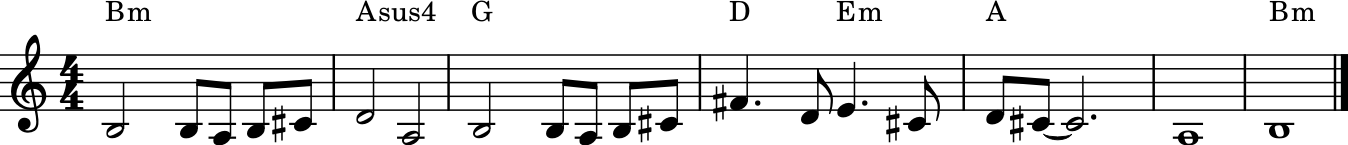

In [14]:
nascence = "INFO treble c 4/4 60 INFO !Bm b3h b3e a3e b3e c#4e !Asus4 d4h a3h !G b3h b3e a3e b3e c#4e !D f#4u d4e !Em e4u c#4e !A d4e c#4{e c#4}d a3w !Bm b3w"

print("Original theme - Nascence")

music(nascence, True)
music(nascence)

Motif v2 - Threshold


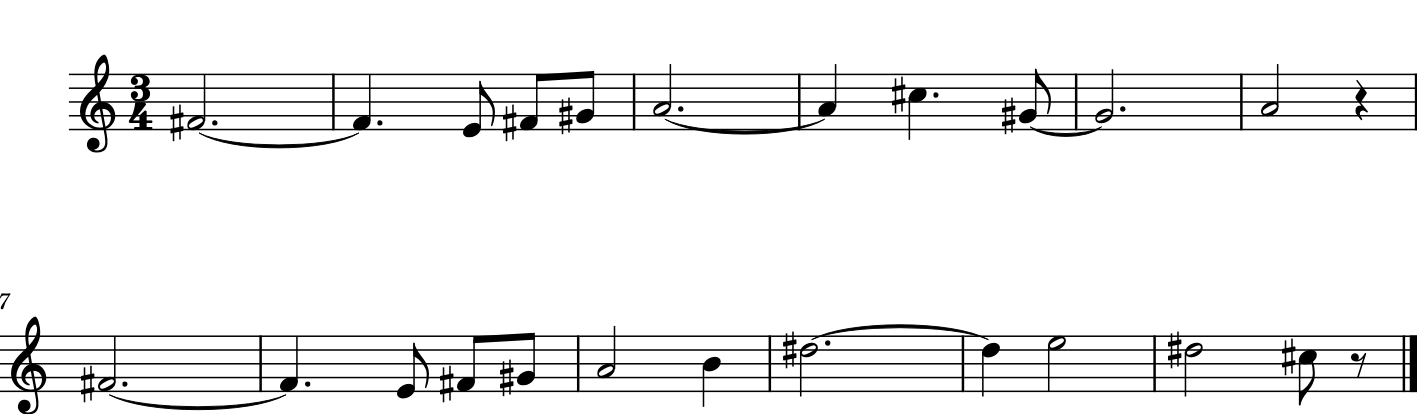

In [17]:
threshold_motif_v2 = "INFO treble c 3/4 130 INFO f#4{d f#4}u e4e f#4e g#4e a4{d a4}q c#5u g#4{e g#4}d a4h rq ^ "
threshold_motif_v2 += "f#4{d f#4}u e4e f#4e g#4e a4h b4q d#5{d d#5}q e5h d#5h c#5e re"

print("Motif v2 - Threshold")

music(threshold_motif_v2, True)
music(threshold_motif_v2)

Motif v3 - Threshold


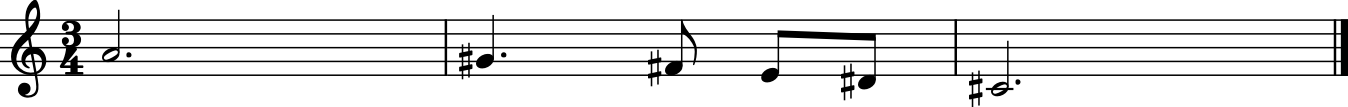

In [21]:
threshold_motif_v3 = "INFO treble c 3/4 130 INFO a4d g#4u f#4e e4e d#4e c#4d"

print("Motif v3 - Threshold")

music(threshold_motif_v3, True)
music(threshold_motif_v3)

Motif v4 - Threshold


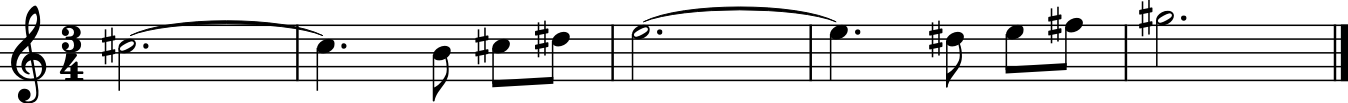

In [22]:
threshold_motif_v4 = "INFO treble c 3/4 130 INFO c#5{d c#5}u b4e c#5e d#5e e5{d e5}u d#5e e5e f#5e g#5d"

print("Motif v4 - Threshold")

music(threshold_motif_v4, True)
music(threshold_motif_v4)

Motif v5 - Apotheosis


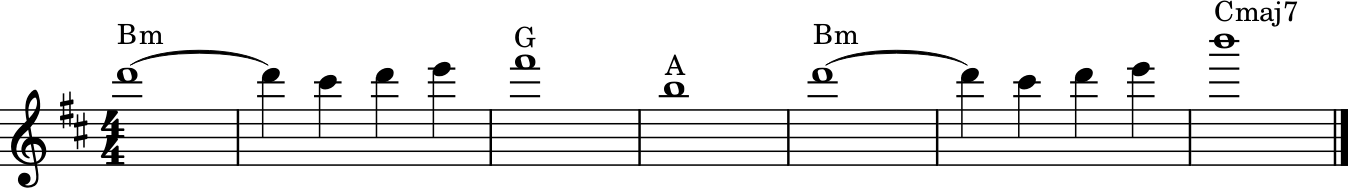

In [28]:
apotheosis = "INFO treble d 4/4 120 INFO !Bm d6{w d6}q c#6q d6q e6q !G f#6w !A b5w !Bm d6{w d6}q c#6q d6q e6q !Cmaj7 b6w"

print("Motif v5 - Apotheosis")

music(apotheosis, True)
music(apotheosis)

*Figure 10.1* An analysis of the thematic development of the original *Journey* theme at different moments in the game. All notes have been placed in the G clef for simplicity.